In [ ]:
%%capture
!pip install langchain langchain_community langchain_openai wikipedia langchain_experimental langsmith pandas langgraph tavily-python

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = openai_api_key
os.environ["TAVILY_API_KEY"] = tavily_api_key

# Статьи и материалы, которые упоминали на занятии

- Generative agents (деревня с агентами, которые могут взаимодействовать) https://arxiv.org/abs/2304.03442 https://reverie.herokuapp.com/arXiv_Demo/
- AI town https://www.convex.dev/ai-town (живая демка, где вы можете повзаимодействовать с агентами) https://github.com/a16z-infra/ai-town?tab=readme-ov-file
- ZeroEval - бенчмарк для ризонинга https://github.com/WildEval/ZeroEval
- Семейство маленьких моделек, которые все любят портировать на русский язык https://huggingface.co/Qwen
- Промптинг для самокоррекции LLM https://arxiv.org/abs/2303.17651
- Фреймворк для мультиагентости от openai https://github.com/openai/swarm

# Концепция мультиагентности

Мультиагентные системы состоят из нескольких автономных агентов, которые взаимодействуют для решения комплексных задач. Каждый агент может обладать специализированными знаниями и способностями, что позволяет эффективно управлять задачами через их взаимодействие.

## Почему мы хотим использовать несколько агентов?

Основные преимущества использования мультиагентных систем:

**Модульность**

По аналогии с микросервисной архитектурой - проще разработать отдельных агентов для каждой из целей.

**Экспертность (специализация)**

Можно создавать агентов-экспертов, специализирующихся на отдельных доменах, что поможет повысить качество.

**Контроль**

Коммуникацию агентов гораздо проще контролировать (в отличии от вызова функций).

### [More Agents Is All You Need](https://arxiv.org/pdf/2402.05120)




В данной статье показали очевидный сценарий взаимодействия агентов, названный Agent Forest. По аналогии с random forest собираем ответы от нескольких агентов и агрегируем их с помощью голосования (выбираем самый частотный).


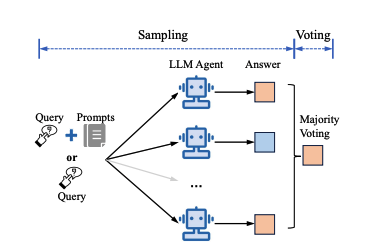

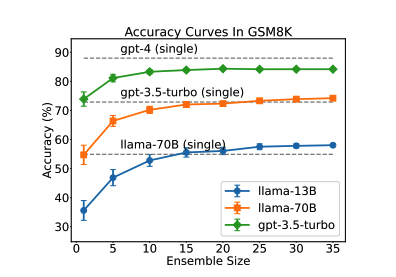

# Архитектуры мультиагентных систем (LangGraph*)

* эта библиотека позволяет визуализировать и управлять мультиагентными пайплайнами. Она представляет агентов в виде узлов в графе, где их связи определяют, как они общаются и сотрудничают при выполнении задач.

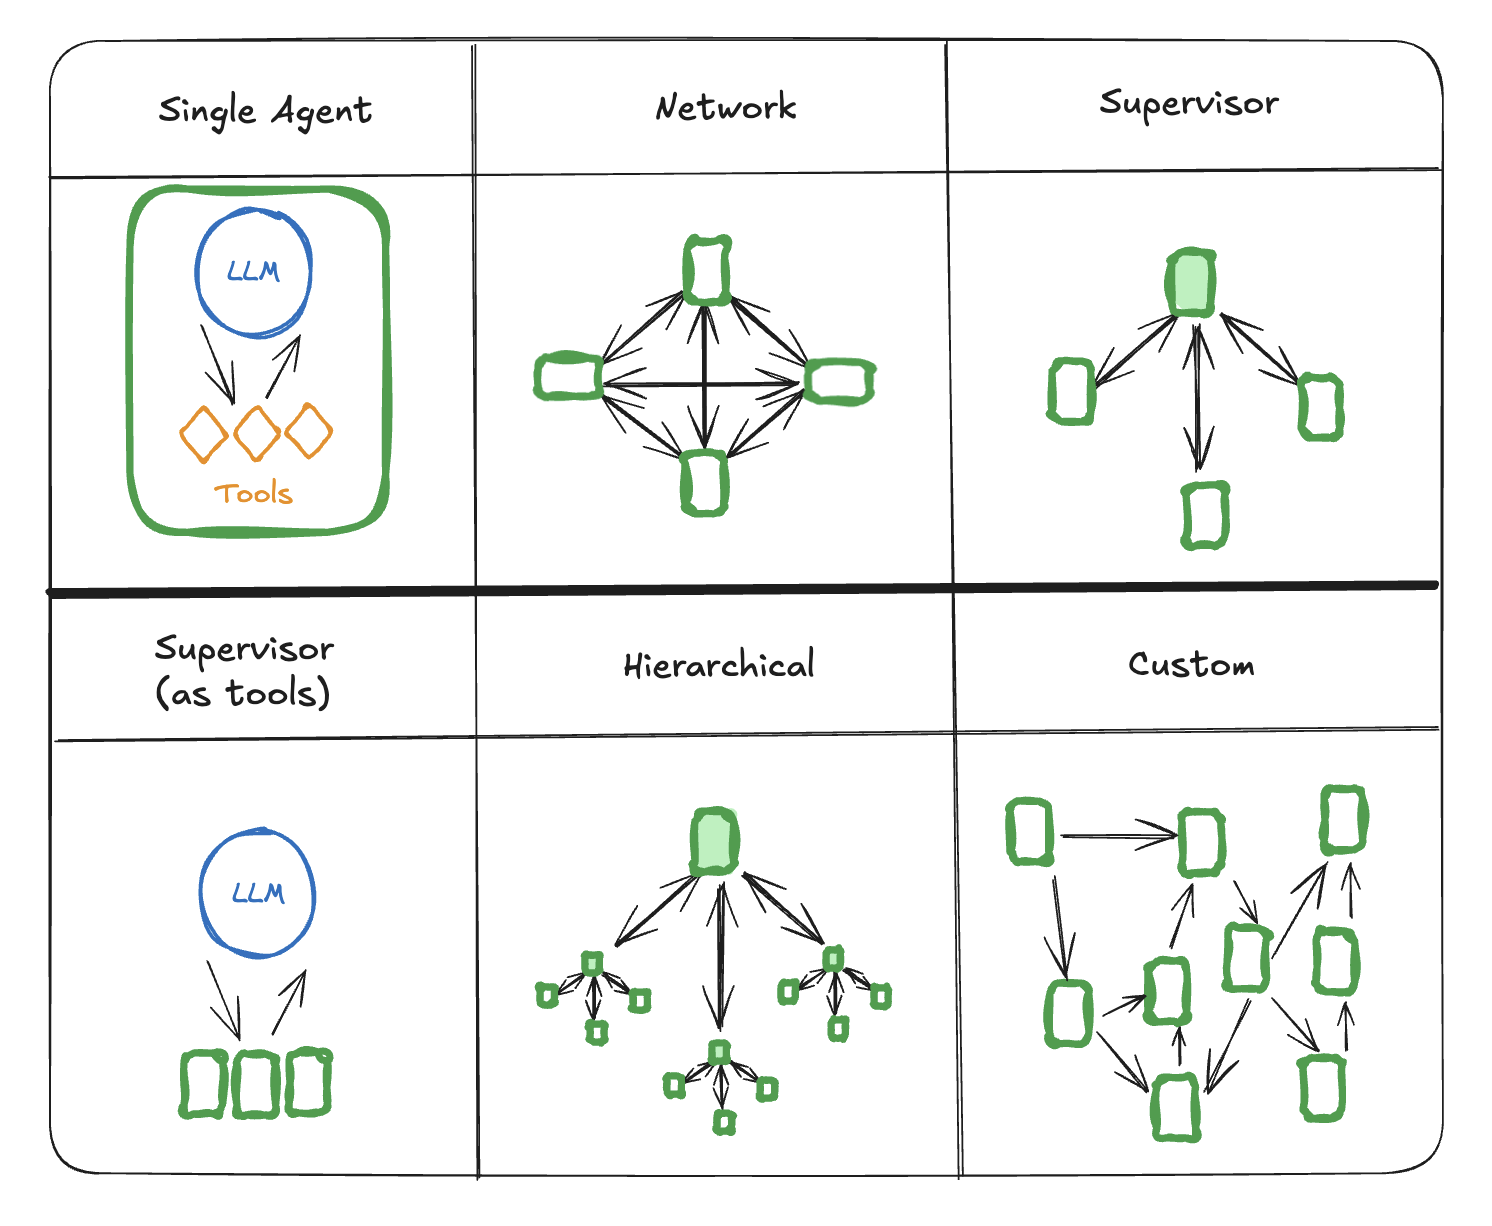

##Supervisor

В этой архитектуре мы определяем агентов как узлы и добавляем узел супервизора (LLM), который решает, какие узлы агентов следует вызвать далее. Мы используем условные ребра для маршрутизации выполнения к соответствующему узлу агента на основе решения супервизора. Эта архитектура также хорошо подходит для параллельного запуска нескольких агентов или использования паттерна map-reduce.

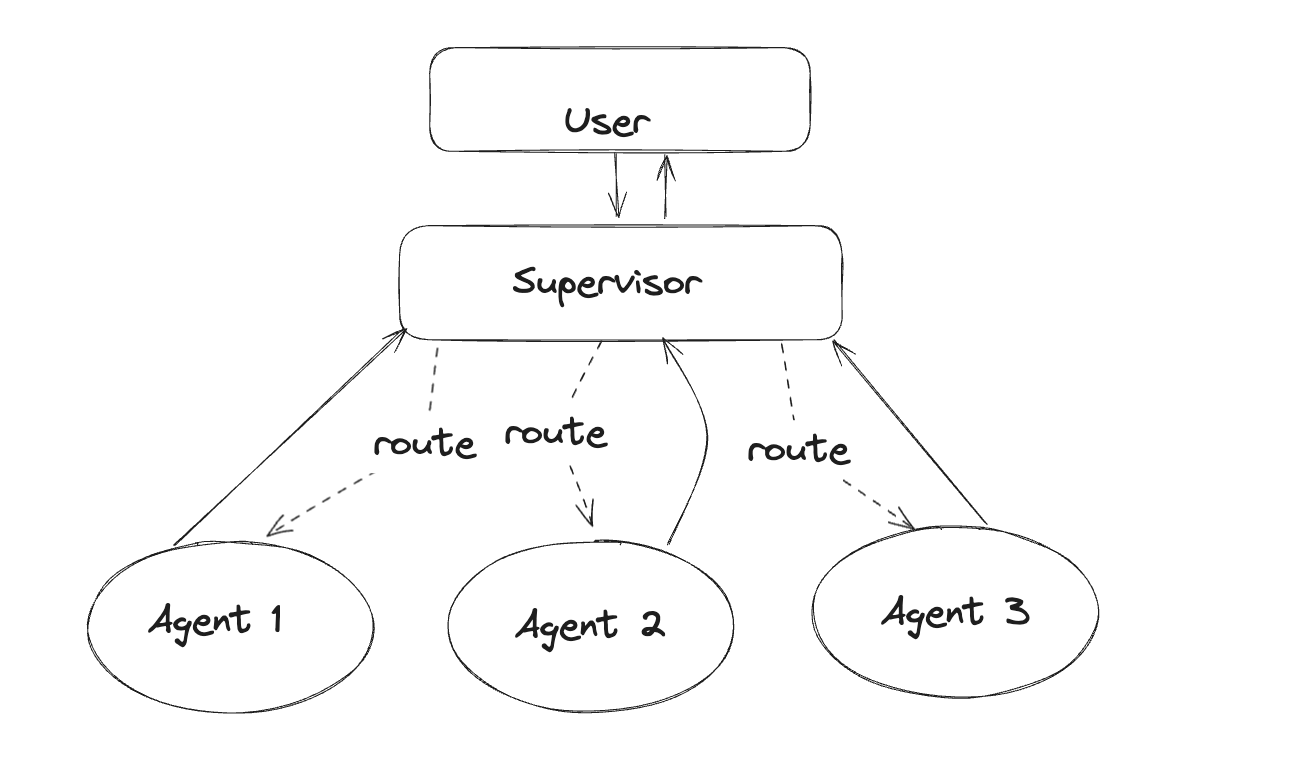

In [ ]:
import functools
import operator

from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from pydantic import BaseModel
from pprint import pprint

from IPython.display import Image, display

from langchain_openai import ChatOpenAI

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

from langchain_experimental.tools import PythonREPLTool
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent

In [ ]:
# search engine для агента Researcherа
tavily_tool = TavilySearchResults(max_results=5)

# python shell для исполнения питоновского кода
python_repl_tool = PythonREPLTool()

# инстанс модели
llm = ChatOpenAI(model="gpt-4o-mini",
                 base_url="https://api.proxyapi.ru/openai/v1")

In [ ]:
# создаем ноду для агента
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [ ]:
# перечисление агентов-исполнителей
members = ["Researcher", "Coder"]
# систем для супервизора
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# добавляем ноду для завершения диалога
options = ["FINISH"] + members


class routeResponse(BaseModel):
    # next: Literal[*options]
    next: Literal["FINISH", "Researcher", "Coder"]

# шаблон промпта для принятия решения
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


In [ ]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# инициализируем агента ресерчера
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# инициализируем агента кодера
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# инициализируем агента-супервизора
supervisor_chain = ( prompt
| llm.with_structured_output(routeResponse)
)

# инициализируем ноды графа
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_chain)

In [ ]:
for member in members:
    # строим ноды графа (объединяем речерчера и кодера с супервизором)
    workflow.add_edge(member, "supervisor")

# добавляем условия перехода для супервизора
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# стартовая нода
workflow.add_edge(START, "supervisor")
# компилируем граф диалога
graph = workflow.compile()

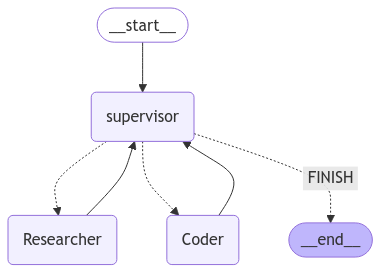

In [ ]:
# визуализируем полученный граф
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Напиши код для приложения с hello world на python")
        ]
    }
):
    if "__end__" not in s:
        for key, value in s.items():
            if 'messages' in value:
              pprint(f'{key}: {value["messages"][-1].content}')
            else:
              print(s)

{'supervisor': {'next': 'Coder'}}
('Coder: Вот простой код для приложения "Hello, World!" на Python:\n'
 '\n'
 '```python\n'
 '# Приложение "Hello, World!"\n'
 'def main():\n'
 '    print("Hello, World!")\n'
 '\n'
 'if __name__ == "__main__":\n'
 '    main()\n'
 '```\n'
 '\n'
 'Этот код определяет функцию `main`, которая выводит строку "Hello, World!". '
 'Когда скрипт запускается, функция `main` вызывается и выполняет вывод. Вы '
 'можете скопировать этот код в файл с расширением `.py` и запустить его с '
 'помощью Python.')
{'supervisor': {'next': 'FINISH'}}


In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Расскажи про ИТМО")
        ]
    }
):
    if "__end__" not in s:
        for key, value in s.items():
            if 'messages' in value:
              pprint(f'{key}: {value["messages"][-1].content}')
            else:
              print(s)

{'supervisor': {'next': 'Researcher'}}
('Researcher: **ИТМО (Университет ИТМО)** — это одно из ведущих высших учебных '
 'заведений России, расположенное в Санкт-Петербурге. Университет был основан '
 'более 120 лет назад и известен своими достижениями в области информационных '
 'технологий, механики и оптики. В советское время он носил название '
 'Ленинградский институт точной механики и оптики (ЛИТМО).\n'
 '\n'
 '### Основные факты:\n'
 '- **Статус**: ИТМО является федеральным государственным автономным учебным '
 'заведением и одной из национальных исследовательских университетов России.\n'
 '- **Рейтинги**: Университет стабильно занимает высокие места в российских и '
 'международных рейтингах. Например, в 2022 году он занимал 365-е место по '
 'версии QS World University Rankings и 601-е по версии Times Higher '
 'Education.\n'
 '- **Научная деятельность**: ИТМО активно сотрудничает с крупными российскими '
 'компаниями и разрабатывает стартапы в области технологий и инноваций. 

## Hierarchial

In [ ]:
import functools
import operator
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Annotated, Dict, List, Optional, Sequence
from typing_extensions import TypedDict

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, HumanMessage, trim_messages
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from langchain_openai import ChatOpenAI
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

In [ ]:
# функции для docwriting team

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

In [ ]:
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)
# инстанс модели
llm = ChatOpenAI(model="gpt-4o-mini",
                 base_url="https://api.proxyapi.ru/openai/v1")
# поисковый движок
tavily_tool = TavilySearchResults(max_results=5)

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


In [ ]:
# нода для агента
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

# функция для создания супервизора
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Research team

In [ ]:
# формат состояния для research team
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str

# поисковый агент
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")
# парсер страниц
research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")
# промпт для супервизора
supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

<ipython-input-20-8626c36494b7>:43: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 0.3.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [ ]:
# создаем и компилируем граф агента
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)

research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

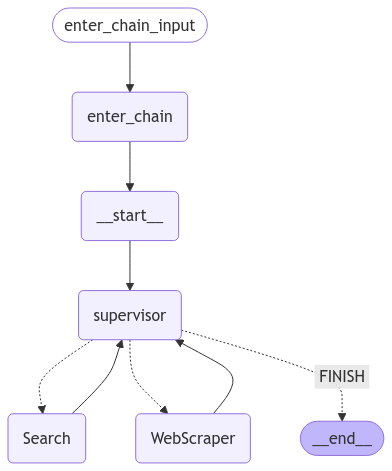

In [ ]:
# визуализация подграфа
display(
    Image(
        research_chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
for s in research_chain.stream(
    "Когда следующая конференция EMNLP?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        for key, value in s.items():
            if 'messages' in value:
              pprint(f'{key}: {value["messages"][-1].content}')
            else:
              print(s)

{'supervisor': {'next': 'Search'}}
('Search: Следующая конференция EMNLP (Empirical Methods in Natural Language '
 'Processing) пройдет с 8 по 10 декабря 2023 года. Она будет проходить в '
 'гибридном формате, сочетая очные и виртуальные мероприятия. Дополнительную '
 'информацию можно найти на [официальном сайте '
 'конференции](https://2023.emnlp.org/).')
{'supervisor': {'next': 'FINISH'}}


### DocWriting Team

In [ ]:
# формат состояния для doc writing team
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }
# агент создатель документов
doc_writer_agent = create_react_agent(
    llm, tools=[write_document, edit_document, read_document]
)

context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)
# агент для создания заметок
note_taking_agent = create_react_agent(llm, tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)
# агент для создания чартов
chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)
# супервизор
doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [ ]:
# создание графа
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# функция, разделяющая подграфы
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

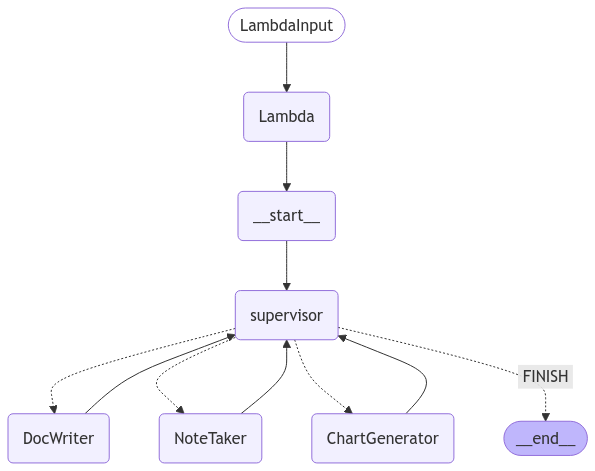

In [ ]:
display(
    Image(
        authoring_chain.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
for s in authoring_chain.stream(
    "Когда следующая конференция EMNLP?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        for key, value in s.items():
            if 'messages' in value:
              pprint(f'{key}: {value["messages"][-1].content}')
            else:
              print(s)

{'supervisor': {'next': 'DocWriter'}}
('DocWriter: Следующая конференция EMNLP (Empirical Methods in Natural '
 'Language Processing) запланирована на 2023 год с 14 по 18 декабря в Китае. '
 'Если вам нужна дополнительная информация о конференции, пожалуйста, дайте '
 'знать!')
{'supervisor': {'next': 'NoteTaker'}}
('NoteTaker: Следующая конференция EMNLP (Empirical Methods in Natural '
 'Language Processing) запланирована на 2023 год с 14 по 18 декабря в Китае. '
 'Если вам нужна дополнительная информация о конференции, пожалуйста, дайте '
 'знать!')
{'supervisor': {'next': 'ChartGenerator'}}
('ChartGenerator: Следующая конференция EMNLP (Empirical Methods in Natural '
 'Language Processing) запланирована на 2023 год с 14 по 18 декабря в Китае. '
 'Если вам нужна дополнительная информация о конференции, пожалуйста, дайте '
 'знать!')
{'supervisor': {'next': 'FINISH'}}


### Team supervisor

In [ ]:
# верхнеуровневый супервизор
supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [ ]:
# состояние для верхних нод
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# создаем граф
super_graph = StateGraph(State)
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

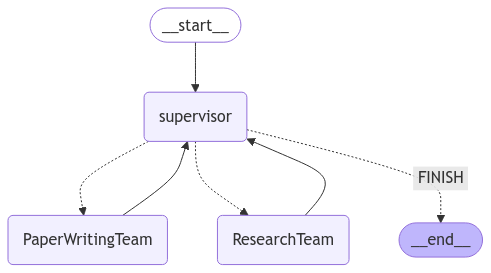

In [ ]:
display(
    Image(
        super_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Напиши отчет о способах взаимодействия LLM агентов, включи в него chart."
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        for key, value in s.items():
            if 'messages' in value:
              pprint(f'{key}: {value["messages"][-1].content}')
            else:
              print(s)

{'supervisor': {'next': 'ResearchTeam'}}
('ResearchTeam: # Отчет о способах взаимодействия LLM агентов\n'
 '\n'
 '## Введение\n'
 'Агенты на основе больших языковых моделей (LLM) становятся все более '
 'популярными в различных областях, включая разработку программного '
 'обеспечения, автоматизацию задач и социальное моделирование. В данном отчете '
 'рассматриваются различные способы взаимодействия таких агентов.\n'
 '\n'
 '## Способы взаимодействия LLM агентов\n'
 '\n'
 '### 1. Конкуренция\n'
 'Конкурирующие агенты работают над достижением собственных целей, которые '
 'могут противоречить целям других агентов. Это может привести к инновационным '
 'решениям, так как агенты вынуждены находить оптимальные стратегии для '
 'достижения своих целей.\n'
 '\n'
 '### 2. Многоуровневая коммуникация\n'
 'Агенты могут взаимодействовать на разных уровнях иерархии. Каждый уровень '
 'имеет заданный порядок и ранг, и агенты в основном взаимодействуют внутри '
 'своего уровня или с соседними уров

In [ ]:
WORKING_DIRECTORY

PosixPath('/tmp/tmpye3iua9y')

# Взаимодействие агентов

## Graph state или Tool calls

Для взаимодействия через графовое состояние отдельные агенты должны быть определены как узлы графа. Их можно добавить в виде функций или целых подграфов. На каждом этапе выполнения графа узел агента получает текущее состояние графа, выполняет код агента и затем передает обновленное состояние следующим узлам.

Обычно узлы агентов используют одну схему состояния. Однако вы можете создать узлы агентов с различными схемами состояния.

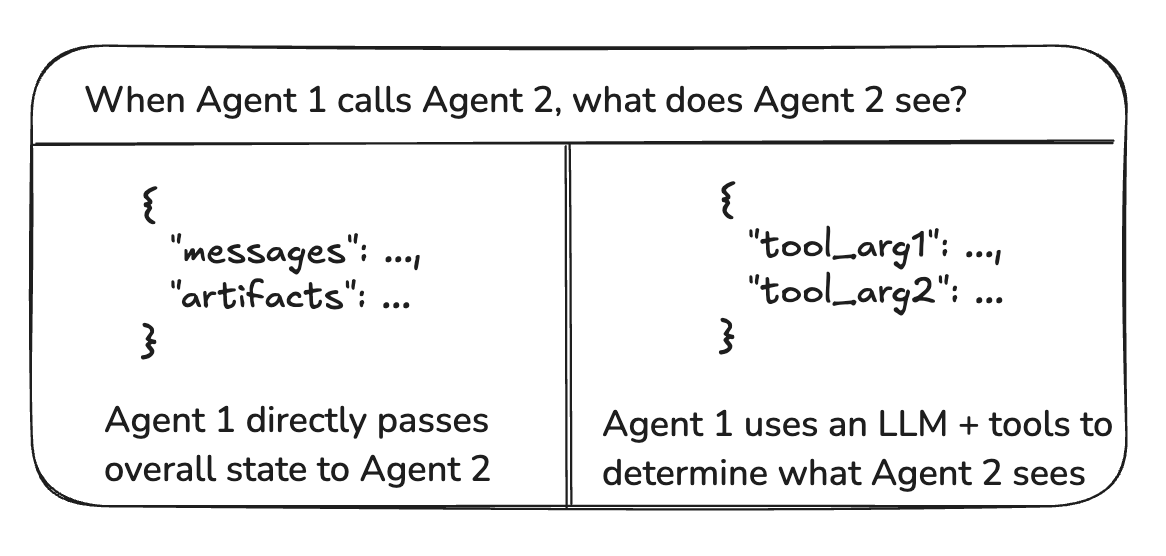

## Общая история сообщений



### Вся цепочка сообщений

Агенты могут делиться полной историей своего мыслительного процесса (т.н. "черновиком") со всеми другими агентами. Этот "черновик" обычно выглядит как список сообщений. Преимущество обмена полной историей мыслительного процесса заключается в том, что это может помочь другим агентам принимать лучшие решения и улучшать способность к рассуждению всей системы в целом.

### Окончательный результат

Агенты могут иметь собственный приватный "черновик" и делиться только окончательным результатом с остальными агентами. Этот подход может лучше работать для систем с большим количеством агентов или для более сложных агентов.

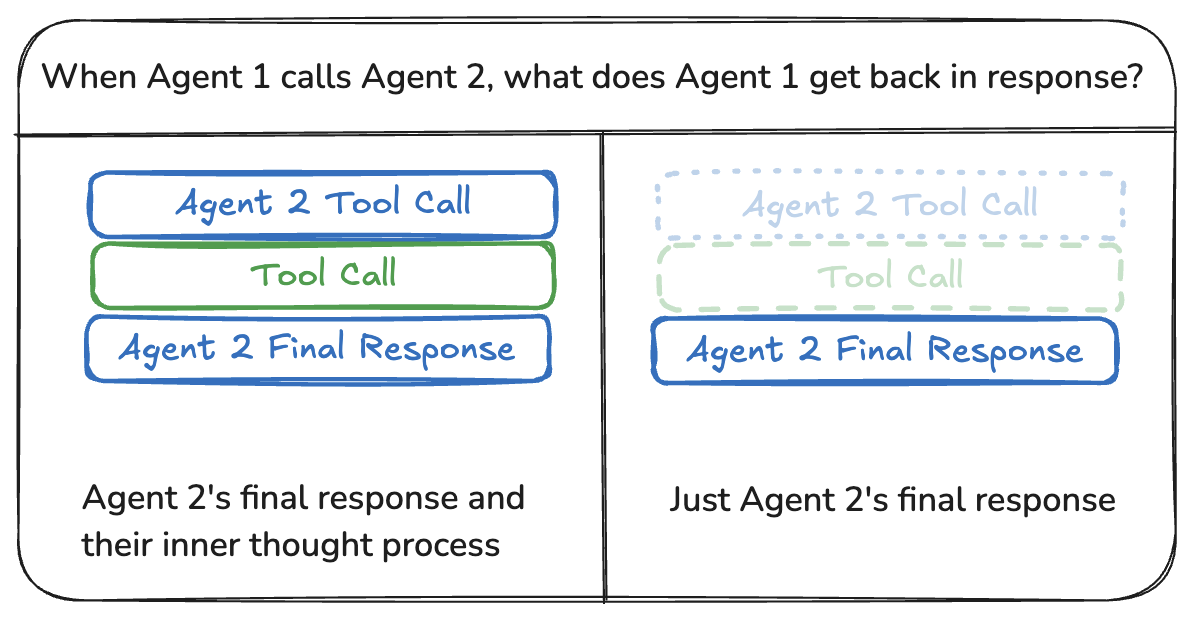

# Агентские фреймворки

## ReACT

ReAct (https://arxiv.org/abs/2210.03629) интегрирует рассуждение и действия в пределах LLM, расширяя пространство действий до комбинации конкретных для задач дискретных действий и языкового пространства. Первое позволяет LLM взаимодействовать с окружающей средой (например, использовать API поиска по Википедии), в то время как второе подталкивает LLM к созданию цепочек рассуждений на естественном языке.

Шаблон подсказки ReAct включает явные шаги для размышлений LLM, примерно оформленные как:

```
Thought: ...
Action: ...
Observation: ...
... (Repeated many times)
```



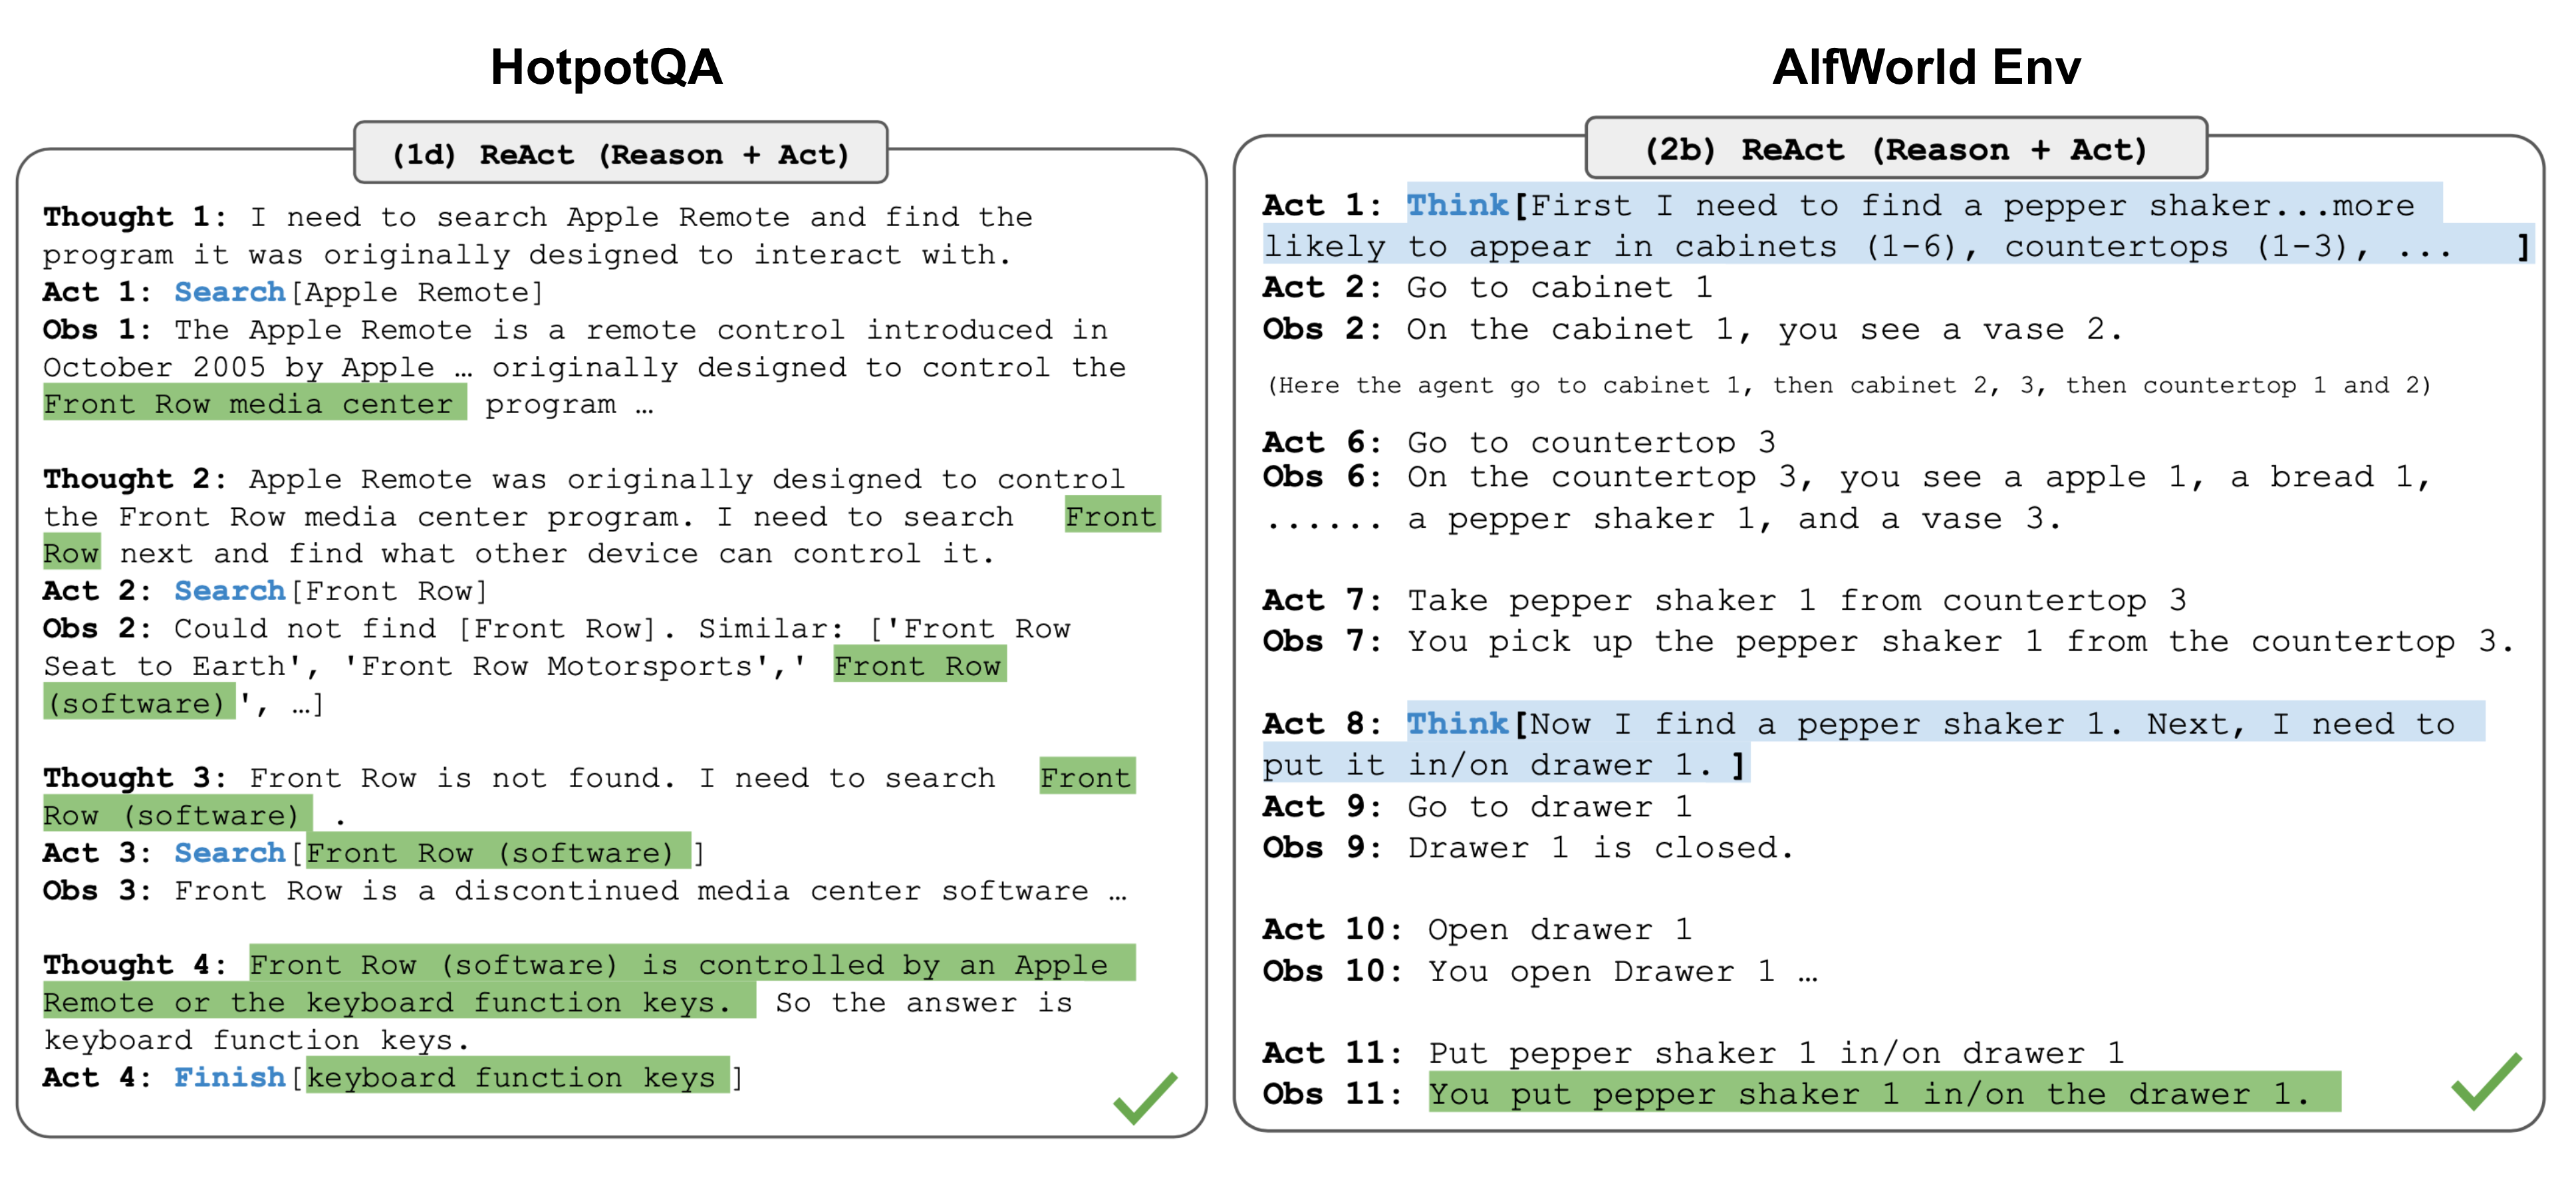


In [ ]:
from langchain.tools import Tool
from langchain.prompts import PromptTemplate
from langchain.agents import AgentExecutor, create_react_agent
from langchain_openai import ChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain_core.messages import AIMessage, HumanMessage

from langchain.agents.react.base import DocstoreExplorer
from langchain.docstore import Wikipedia
from langchain.tools.render import render_text_description

In [ ]:
# Initialize DocstoreExplorer with Wikipedia as the document source
docstore = DocstoreExplorer(Wikipedia())


# Define available tools with their functionalities and descriptions
tools = [
    Tool(
        name="Search",
        func=docstore.search,
        description="useful for when you need to ask with search",
    ),
    Tool(
        name="Lookup",
        func=docstore.lookup,
        description="useful for when you need to ask with lookup",
    ),
]

prompt_template = """
You are an AI agent talking to a human. ... You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer

Thought: you should always think about what to do

Action: the action to take, should be one of [{tool_names}]

Action Input: the input to the action

Observation: the result of the action

... (this Thought/Action/Action Input/Observation can repeat N times)

Thought: I now know the final answer

Final Answer: the final answer to the original input question

Begin!

Question: {input}

Thought: {agent_scratchpad}
"""

prompt = PromptTemplate.from_template(template=prompt_template).partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)


<ipython-input-36-0a6f8f43f9d8>:2: LangChainDeprecationWarning: The class `DocstoreExplorer` was deprecated in LangChain 0.1.0 and will be removed in 1.0
  docstore = DocstoreExplorer(Wikipedia())


In [ ]:
# Initialize the chat model
llm = ChatOpenAI(model="gpt-4o-mini",
                 base_url="https://api.proxyapi.ru/openai/v1")

In [ ]:
prompt

PromptTemplate(input_variables=['agent_scratchpad', 'input'], input_types={}, partial_variables={'tools': "Search(term: 'str') -> 'str' - useful for when you need to ask with search\nLookup(term: 'str') -> 'str' - useful for when you need to ask with lookup", 'tool_names': 'Search, Lookup'}, template='\nYou are an AI agent talking to a human. ... You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\n\nThought: you should always think about what to do\n\nAction: the action to take, should be one of [{tool_names}]\n\nAction Input: the input to the action\n\nObservation: the result of the action\n\n... (this Thought/Action/Action Input/Observation can repeat N times)\n\nThought: I now know the final answer\n\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\n\nThought: {agent_scratchpad}\n')

In [ ]:
agent = create_react_agent(llm, tools, prompt)

In [ ]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)

In [ ]:
agent_executor.invoke(
    {
        "input": "tell something about history of physics",
        "agent_scratchpad": []
    }
)



> Entering new AgentExecutor chain...
I need to provide an overview or some interesting facts about the history of physics. To do this effectively, I should gather some key points or notable developments in the field.

Action: Search

Action Input: 'history of physics'
Physics is a branch of science whose primary objects of study are matter and energy. Discoveries of physics find applications throughout the natural sciences and in technology. Historically, physics emerged from the scientific revolution of the 17th century, grew rapidly in the 19th century, then was transformed by a series of discoveries in the 20th century. Physics today may be divided loosely into classical physics and modern physics.
Many detailed articles on specific topics are available through the Outline of the history of physics.I have gathered some background information about the history of physics. It includes its emergence from the scientific revolution, growth in the 19th century, and transformations in t

{'input': 'tell something about history of physics',
 'agent_scratchpad': [],
 'output': 'The history of physics emerged from the scientific revolution of the 17th century, saw rapid growth in the 19th century, and underwent significant transformations due to discoveries in the 20th century. Today, physics is divided into classical and modern branches, with applications across natural sciences and technology.'}

## Reflexion

Reflexion (https://arxiv.org/abs/2303.11366) — это структура, которая оснащает агентов динамической памятью и способностями к саморефлексии для улучшения навыков рассуждения. Reflexion имеет стандартную настройку RL, в которой модель вознаграждений предоставляет простое бинарное вознаграждение, а пространство действий следует настройке в ReAct, где пространство действий, специфичное для задачи, дополнено языком для выполнения сложных шагов рассуждения.

После каждого действия агент вычисляет эвристику и, при необходимости, может принять решение сбросить среду для начала нового испытания в зависимости от результатов саморефлексии.

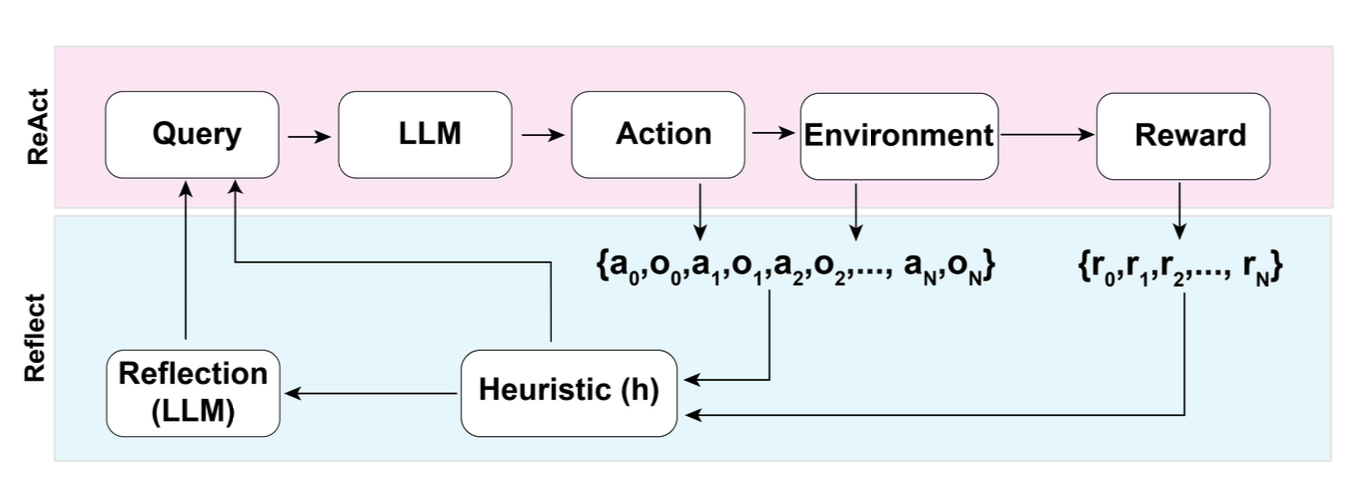

Эвристическая функция определяет, когда траектория неэффективна или содержит галлюцинации и должна быть остановлена. Неэффективное планирование относится к траекториям, которые занимают слишком много времени без достижения успеха. Галлюцинация определяется как встреча последовательности одинаковых действий, приводящих к одному и тому же наблюдению в среде.

Саморефлексия создается путем демонстрации двумерных примеров LLM, и каждый пример представляет собой пару (неудачная траектория, идеальное размышление для руководства будущими изменениями в плане). Затем размышления добавляются в рабочую память агента, максимум три, чтобы использовать их в качестве контекста для запросов LLM.

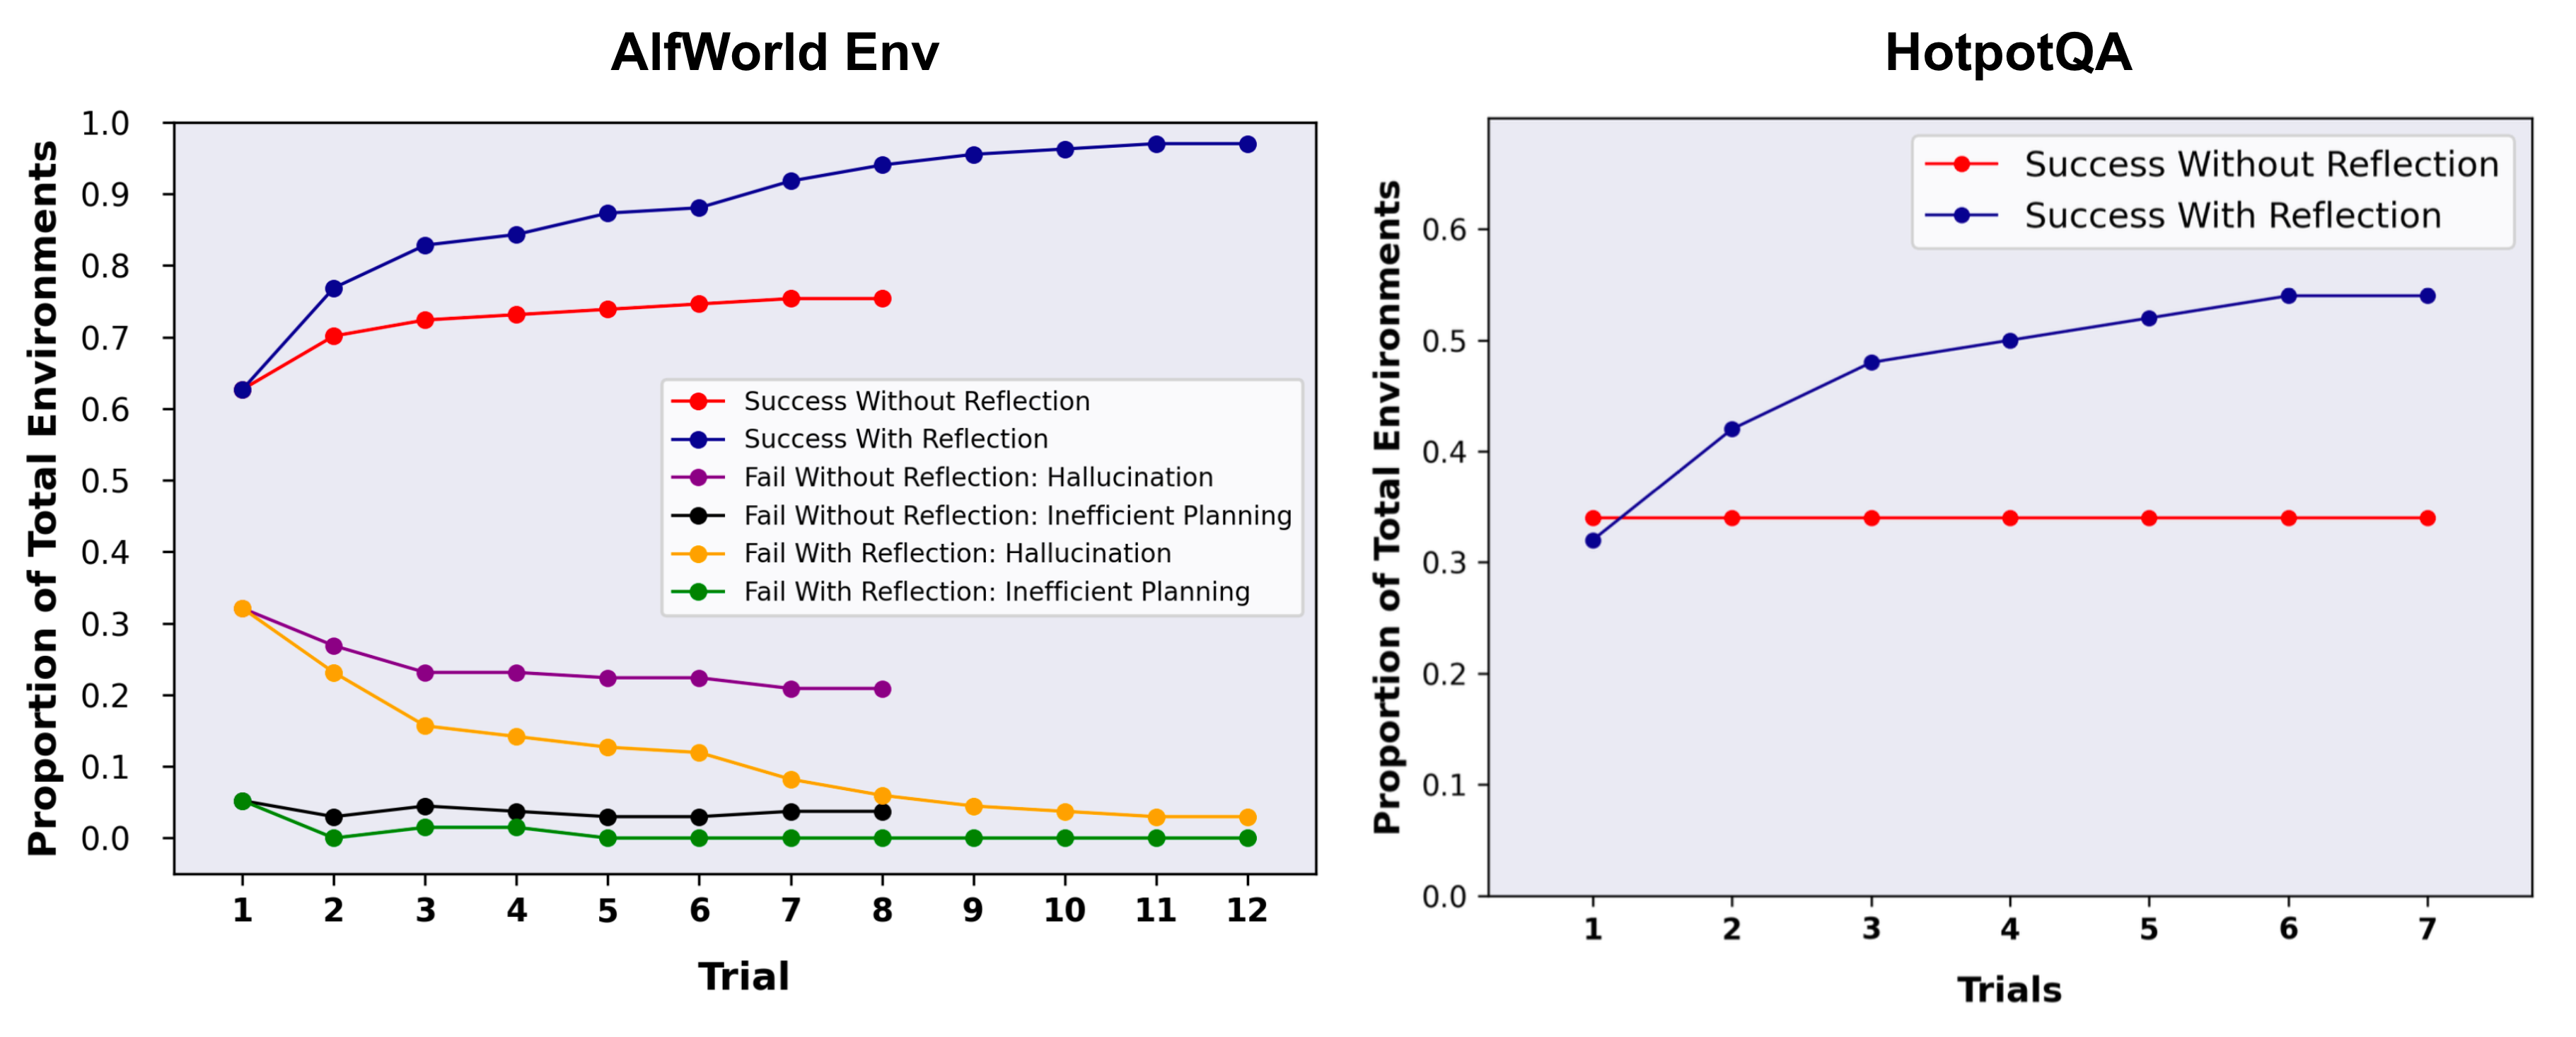

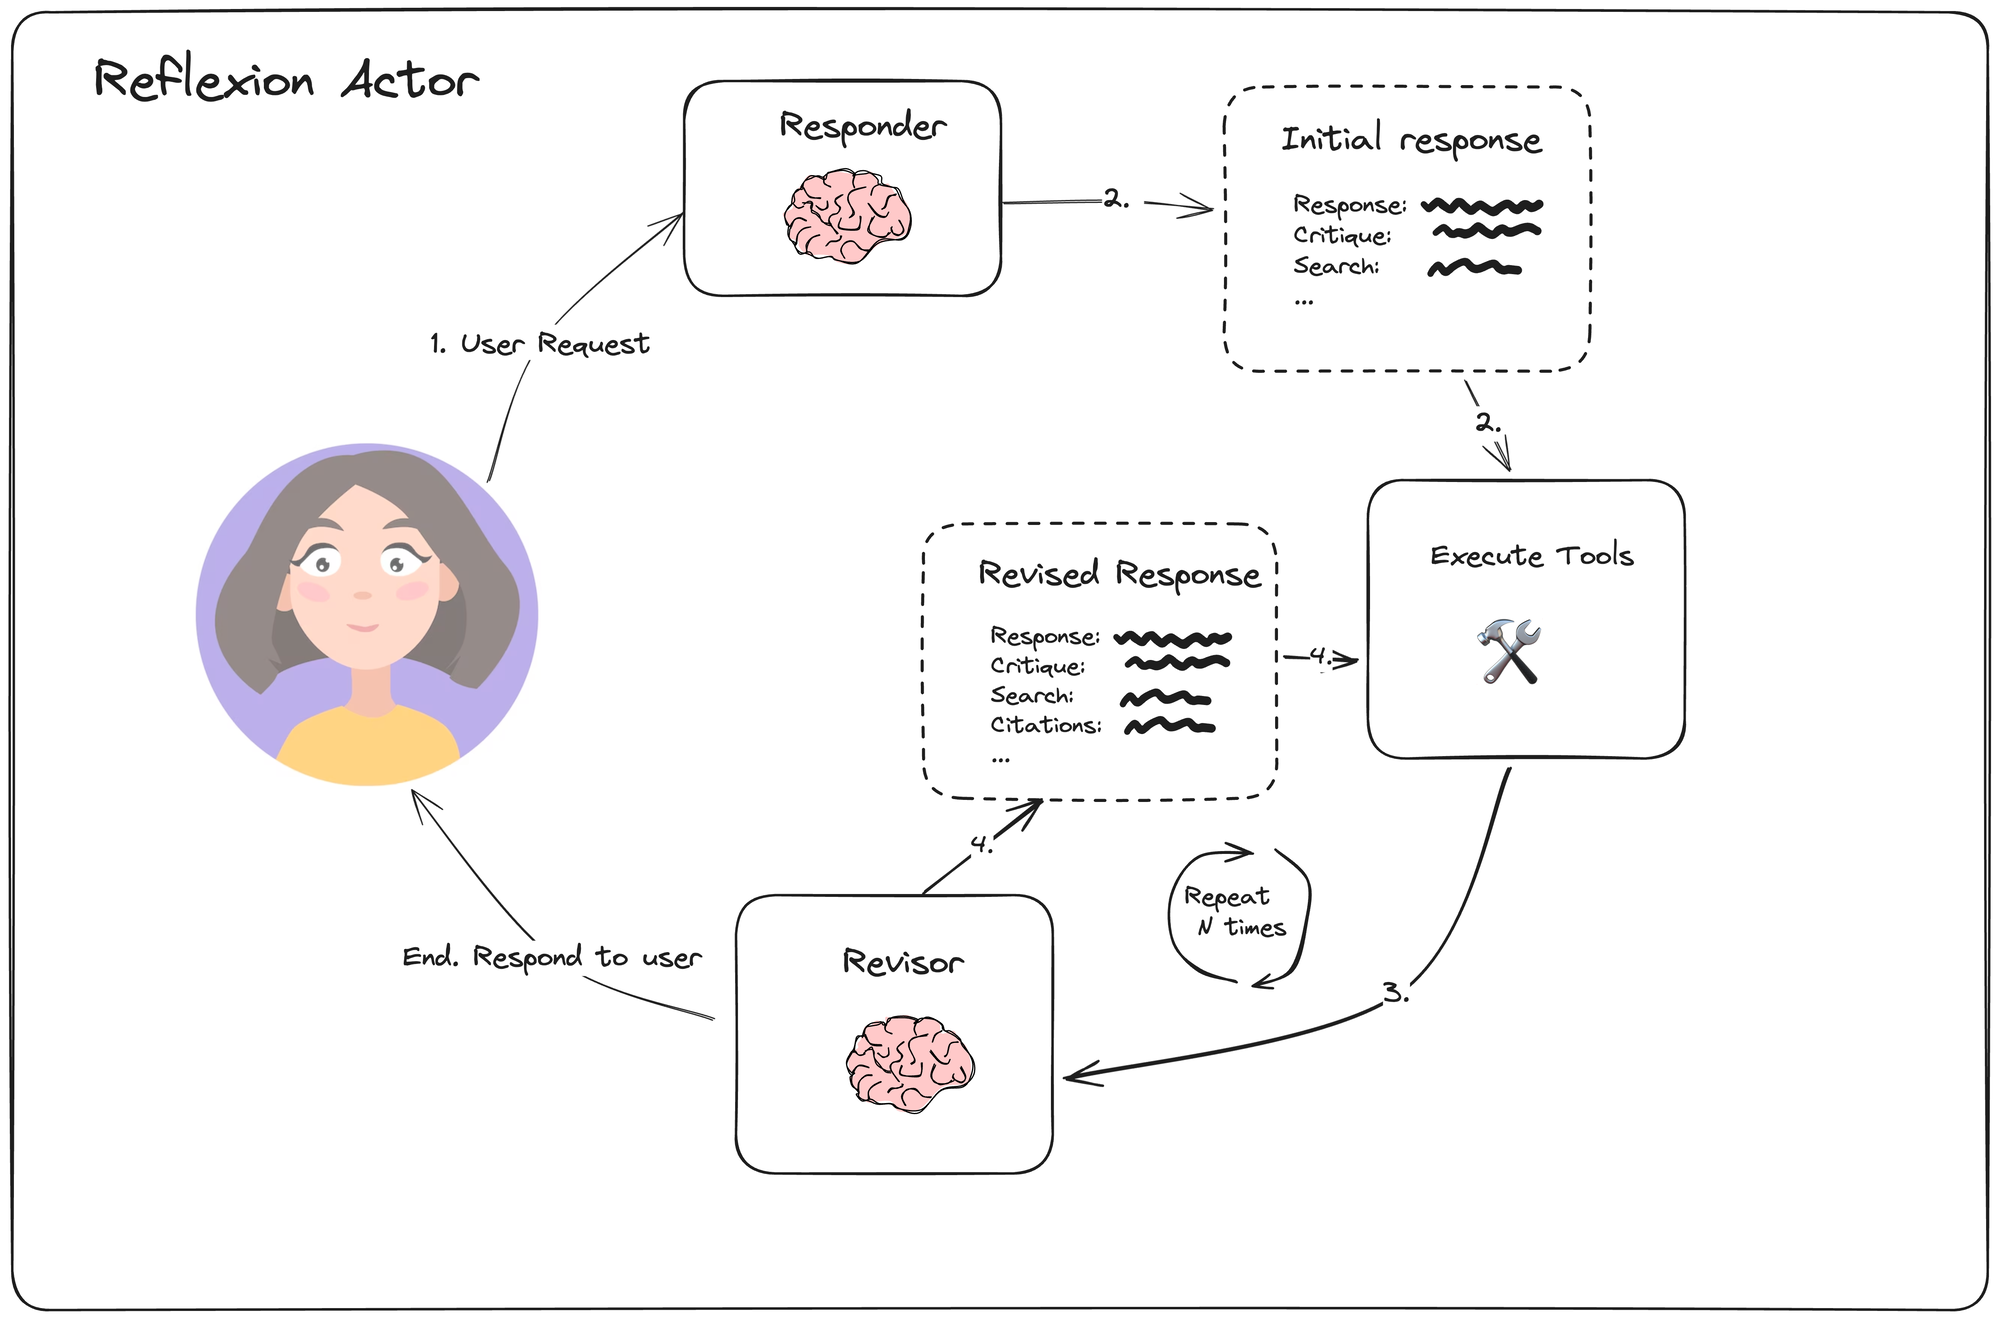

In [ ]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.tools import StructuredTool

from langchain_openai import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

from pydantic import BaseModel, Field, ValidationError

from typing import Annotated, Literal
from typing_extensions import TypedDict

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 base_url="https://api.proxyapi.ru/openai/v1")
tavily_tool = TavilySearchResults(max_results=5)

In [ ]:
# схема рефлексии
class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")

# схема ответов
class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

# ответ с попытками улучшения
class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: dict):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state["messages"]}, {"tags": [f"attempt:{attempt}"]}
            )
            try:
                self.validator.invoke(response)
                return {"messages": response}
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return {"messages": response}

In [ ]:
# создаем промпт для актора
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
)

initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [ ]:
# создаем стадию рефлексии
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [ ]:
def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [ ]:
# создаем граф агента
class State(TypedDict):
    messages: Annotated[list, add_messages]


MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)

builder.add_edge("draft", "execute_tools")
builder.add_edge("execute_tools", "revise")


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i

def event_loop(state: list):
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state["messages"])
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop, ["execute_tools", END])
builder.add_edge(START, "draft")
graph = builder.compile()

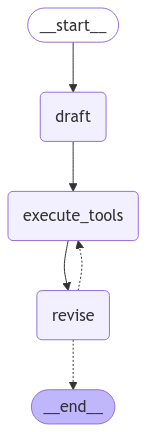

In [ ]:
# визуализируем граф
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
events = graph.stream(
    {"messages": [("user", "How to build multiagent system with langchain?")]},
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step["messages"][-1].pretty_print()

Step 0
================================ Human Message =================================

How to build multiagent system with langchain?
Step 1
================================== Ai Message ==================================
Tool Calls:
  AnswerQuestion (call_o5oYihYBDtCIxk3KyihIbCdk)
 Call ID: call_o5oYihYBDtCIxk3KyihIbCdk
  Args:
    answer: Building a multi-agent system with LangChain involves several steps that integrate the framework's capabilities with the design of autonomous agents. LangChain is a framework designed for developing applications using language models, and it provides tools for creating agents that can interact with various environments and carry out tasks based on user input or predefined goals.

1. **Define Agent Objectives**: Start by outlining what tasks or objectives your agents should accomplish. This could range from answering questions, performing web scraping, or interacting with APIs.

2. **Choose Language Models**: Select appropriate language models for 

## Еще материалы по агентам

- [Блогпост по типам агенто](https://lilianweng.github.io/posts/2023-06-23-agent/)в (до середины 2023)
- [ReACT Super](https://arxiv.org/pdf/2409.07440v1) — вариация ReACT с дополнительным действием Edit для облегченного редактирования файлов в обход bash-скриптов (агенты тоже плохо выходят из vim, видимо)
- [AIDE / Solution Space Tree Search](https://www.weco.ai/blog/technical-report) — метод поиска по дереву агентных решений, максимизирует качество в лимитированное время. Нужны модель-генератор, оценщик и селектор решений.
- [MLAB из MLAgentBench](https://openreview.net/forum?id=1Fs1LvjYQW) — включает Reflection, Research
Plan and Status, Fact Check, Thought, а еще Action и Action Input.
- [Gödel Agent: A Self-Referential Agent Framework for Recursive Self-Improvement](https://arxiv.org/abs/2410.04444 )



# Способы оценки агентов

Оценка LLM агентов, так же как и оценка самих LLM, является сложной задачей. Распространенные методы оценки включают:

**Разметка**: Включает разметчиков, которые напрямую оценивают результаты LLM по различным аспектам, важным для приложения, таким как честность, полезность, вовлеченность, беспристрастность и другие.

**Тест тьюринга/SBS**: разметчикам предлагается сравнивать результаты от реальных людей и агентов, где неразличимые результаты означают, что агенты могут достигать производительности, схожей с человеческой.

**Метрики**: Применимые к задаче формализуемые критерии, отражающие качество агентов. К важным метрикам относятся метрики успешности выполнения задач, метрики схожести с человеком и метрики эффективности.

**Протоколы**: Выполнение определенных наборов действий, которые можно оценить автоматичеси.

**Бенчмарки**: [MLE bench](https://https://arxiv.org/abs/2410.07095), [Agent as Judge](https://arxiv.org/abs/2410.10934), [AgentBench](https://arxiv.org/abs/2308.03688), [LLMArena](https://arxiv.org/pdf/2402.16499), [AppWorld](https://arxiv.org/pdf/2407.18901v1)

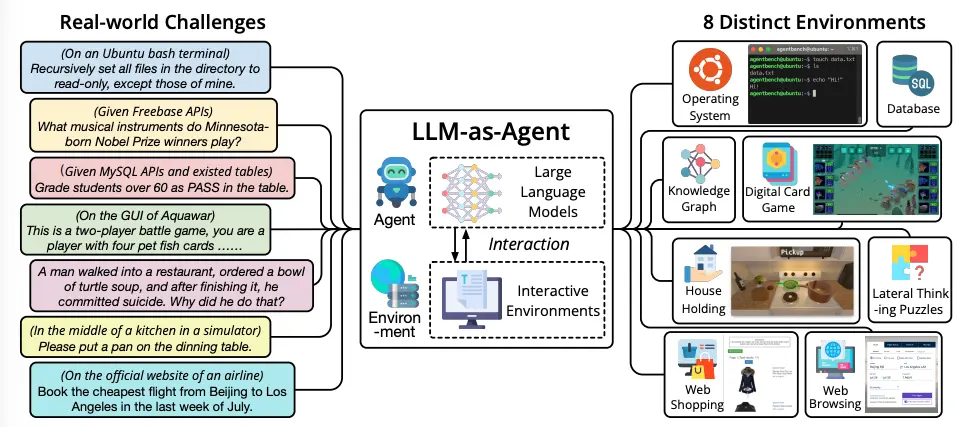

# RAG agent and multiagent bot with RAG

## Single RAG agent

In [ ]:
import functools
import operator
from pprint import pprint
from pydantic import BaseModel, Field
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from IPython.display import Image, display

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.vectorstores import InMemoryVectorStore

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema import Document
from langchain.retrievers import TFIDFRetriever

from langchain.text_splitter import CharacterTextSplitter

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.tools.retriever import create_retriever_tool

from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import create_react_agent

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini",
                 temperature=0,
                 base_url="https://api.proxyapi.ru/openai/v1")

# База документов для примера, преобразуем каждый документ в объект Document
documents = [
    Document(page_content="Мультиагентные системы состоят из нескольких автономных агентов, которые взаимодействуют для решения комплексных задач. Каждый агент может обладать специализированными знаниями и способностями, что позволяет эффективно управлять задачами через их взаимодействие."),
    Document(page_content="""
Основные преимущества использования мультиагентных систем:

**Модульность**

По аналогии с микросервисной архитектурой - проще разработать отдельных агентов для каждой из целей.

**Экспертность (специализация)**

Можно создавать агентов-экспертов, специализирующихся на отдельных доменах, что поможет повысить качество.

**Контроль**

Коммуникацию агентов гораздо проще контролировать (в отличии от вызова функций)."""),
    Document(page_content="LangGraph эта библиотека позволяет визуализировать и управлять мультиагентными пайплайнами. Она представляет агентов в виде узлов в графе, где их связи определяют, как они общаются и сотрудничают при выполнении задач."),
]

# Разделение документов на фрагменты для улучшения поиска
text_splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=20)
texts = text_splitter.split_documents(documents)

# Создание индекса TF-IDF для поиска по текстам
# Создаем новый список документов для TFIDFRetriever
retriever = TFIDFRetriever.from_documents(texts)


tool = create_retriever_tool(
    retriever,
    "text_retriever",
    "Searches and returns excerpts from multiagent systems.",
)
tools = [tool]

# RAG agent
retriever_agent = create_react_agent(llm, tools)

In [ ]:
result = retriever_agent.invoke(
{"messages": [("user", "Расскажи о мультиагентных системах?")]}
)
result['messages'][-1].content

'Мультиагентные системы состоят из нескольких автономных агентов, которые взаимодействуют для решения комплексных задач. Каждый агент может обладать специализированными знаниями и способностями, что позволяет эффективно управлять задачами через их взаимодействие.\n\nОсновные характеристики мультиагентных систем:\n\n1. **Контроль**: Коммуникацию агентов гораздо проще контролировать, чем вызов функций, что упрощает управление взаимодействием.\n\n2. **Экспертность (специализация)**: Можно создавать агентов-экспертов, специализирующихся на отдельных доменах, что помогает повысить качество выполнения задач.\n\n3. **Визуализация и управление**: Существуют инструменты, такие как LangGraph, которые позволяют визуализировать и управлять мультиагентными пайплайнами, представляя агентов в виде узлов в графе, где их связи определяют, как они общаются и сотрудничают при выполнении задач.\n\nМультиагентные системы находят применение в различных областях, включая робототехнику, управление ресурсами, 

## Multiagent system with RAG

In [ ]:
# создаем ноду для агента
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

In [ ]:
# перечисление агентов-исполнителей
members = ["Retriever", "OutputRewriter", "Translator"]
# систем для супервизора
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

tavily_tool = TavilySearchResults(max_results=5)

# добавляем ноду для завершения диалога
options = ["FINISH"] + members


class routeResponse(BaseModel):
    # next: Literal[*options]
    next: Literal["Retriever", "OutputRewriter", "Translator", "FINISH"]

# шаблон промпта для принятия решения
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


In [ ]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


retriever_node = functools.partial(agent_node, agent=retriever_agent, name="Retriever")
# инициализируем агента-переводчика
translator_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier='Переведи ответ на испанский')
editor_node = functools.partial(agent_node, agent=translator_agent, name="Translator")

# инициализируем агента для объяснений
rewriter_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier='Объясни как пятилетнему ребенку')
rewriter_node = functools.partial(agent_node, agent=rewriter_agent, name="OutputRewriter")

# инициализируем агента-супервизора
supervisor_chain = ( prompt
| llm.with_structured_output(routeResponse)
)

# инициализируем ноды графа
workflow = StateGraph(AgentState)
workflow.add_node("Translator", editor_node)
workflow.add_node("Retriever", retriever_node)
workflow.add_node("OutputRewriter", rewriter_node)
workflow.add_node("supervisor", supervisor_chain)

In [ ]:
for member in members:
    # строим ноды графа (объединяем речерчера и кодера с супервизором)
    workflow.add_edge(member, "supervisor")

# добавляем условия перехода для супервизора
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# стартовая нода
workflow.add_edge(START, "supervisor")
# компилируем граф диалога
graph = workflow.compile()

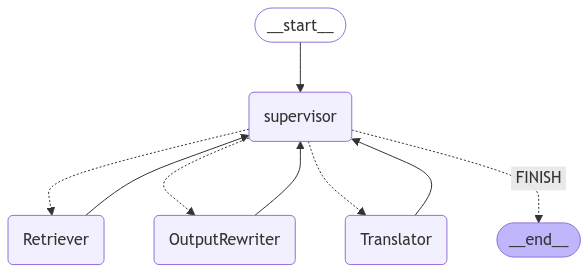

In [ ]:
# визуализируем полученный граф
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Расскажи что-нибудь о мультиагентных системах (не вызывай переводчик)")
        ]
    }
):
    if "__end__" not in s:
        for key, value in s.items():
            if 'messages' in value:
              pprint(f'{key}: {value["messages"][-1].content}')
            else:
              print(s)

{'supervisor': {'next': 'Retriever'}}
('Retriever: Мультиагентные системы (МАС) представляют собой класс систем, '
 'состоящих из множества взаимодействующих агентов, которые могут быть как '
 'программными, так и физическими. Эти агенты способны автономно принимать '
 'решения, взаимодействовать друг с другом и с окружающей средой для '
 'достижения своих целей.\n'
 '\n'
 'Основные характеристики мультиагентных систем:\n'
 '\n'
 '1. **Автономия**: Каждый агент может действовать независимо, основываясь на '
 'своих собственных знаниях и восприятии окружающей среды.\n'
 '\n'
 '2. **Взаимодействие**: Агенты могут обмениваться информацией, координировать '
 'свои действия и сотрудничать для достижения общих целей.\n'
 '\n'
 '3. **Дистрибуция**: МАС часто распределены по различным узлам сети, что '
 'позволяет им работать в различных условиях и масштабах.\n'
 '\n'
 '4. **Адаптивность**: Агенты могут адаптироваться к изменениям в окружающей '
 'среде и изменять свои стратегии в ответ на нов

In [ ]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Расскажи что-нибудь о мультиагентных системах ")
        ]
    }
):
    if "__end__" not in s:
        for key, value in s.items():
            if 'messages' in value:
              pprint(f'{key}: {value["messages"][-1].content}')
            else:
              print(s)

{'supervisor': {'next': 'Retriever'}}
('Retriever: Мультиагентные системы состоят из нескольких автономных агентов, '
 'которые взаимодействуют для решения комплексных задач. Каждый агент может '
 'обладать специализированными знаниями и способностями, что позволяет '
 'эффективно управлять задачами через их взаимодействие.\n'
 '\n'
 'Одним из инструментов для работы с мультиагентными системами является '
 'библиотека LangGraph, которая позволяет визуализировать и управлять '
 'мультиагентными пайплайнами. В этой библиотеке агенты представлены в виде '
 'узлов в графе, а их связи определяют, как они общаются и сотрудничают при '
 'выполнении задач.\n'
 '\n'
 'Основные преимущества мультиагентных систем включают:\n'
 '\n'
 '1. **Контроль**: Коммуникацию агентов гораздо проще контролировать по '
 'сравнению с вызовом функций.\n'
 '2. **Экспертность (специализация)**: Можно создавать агентов-экспертов, '
 'специализирующихся на отдельных доменах, что помогает повысить качество '
 'выполне